##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introducción a los autocodificadores

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/autoencoder.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     Ver código fuente en GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar notebook</a>   </td>
</table>

En este tutorial, se presentan los autocodificadores con tres ejemplos: fundamentos, eliminación de ruidos y detección de anomalías.

Un autocodificador es un tipo de red neuronal especial que es entrenado para que copie su propia entrada en la salida. Por ejemplo, si se ingresa una imagen con una cifra escrita a mano, un autocodificador primero codifica la imagen en una representación latente de menor dimensión, luego vuelve a decodificar la representación latente en una imagen. Un autocodificador aprende a comprimir los datos mientras minimiza errores de reconstrucción.

Para obtener más información sobre los autocodificadores, considere leer el capítulo 14 de [Aprendizaje profundo](https://www.deeplearningbook.org/) de Ian Goodfellow, Yoshua Bengio, y Aaron Courville.

## Importar TensorFlow y otras bibliotecas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Cargar el conjunto de datos

Para empezar, entrenará un autocodificador básico con el conjunto de datos MNIST de moda. Cada imagen en el conjunto de datos es de 28x28 píxeles.

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Primer ejemplo: autocodificador básico

![Basic autoencoder results](images/intro_autoencoder_result.png)

Defina un autocodificador con dos capas densas: un `encoder`, que comprime las imágenes en un vector latente de 64 dimensiones y un `decoder`, que reconstruye la imagen original desde el espacio latente.

Para definir su modelo, use la [API de subclasificación del modelo de Keras](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [4]:
import numpy as np

class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super().__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    # aquí lo arreglamos:
    num_pixels = int(np.prod(shape))        # → 784
    self.decoder = tf.keras.Sequential([
      layers.Dense(num_pixels, activation='sigmoid'),
      layers.Reshape(shape)
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Entrene el modelo con `x_train` como la entrada y la salida. El `encoder` aprenderá a comprimir los conjuntos de datos de 784 dimensiones en el espacio latente, y el `decoder` aprenderá a reconstruir las imágenes originales.

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 15s 7ms/step - loss: 0.0239 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0

Ahora que el modelo está entrenado, probemos la codificación y decodificación de imágenes en el conjunto de prueba.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

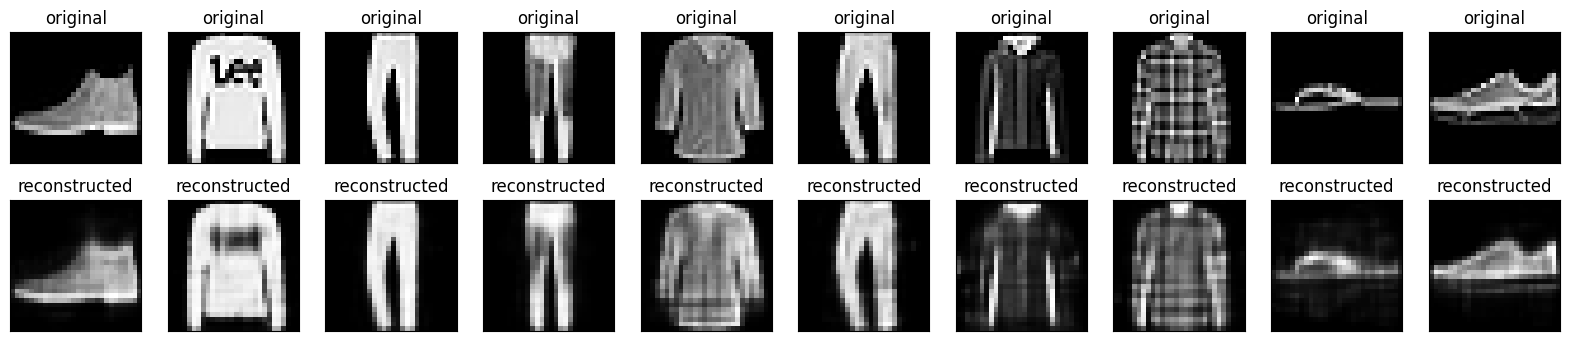

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Segundo ejemplo: eliminación de ruidos de la imagen

![Image denoising results](images/image_denoise_fmnist_results.png)

También se puede entrenar un autocodificador para eliminar el ruido de las imágenes. En la siguiente sección, creará una versión con ruido del conjunto de datos MNIST de moda y aplicará ruido aleatorio en cada imagen. Luego, entrenará al autocodificador con una imagen con ruido como entrada y la imagen original como el destino.

Importaremos el conjunto de datos para omitir las modificaciones hechas anteriormente.

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Agregamos ruido aleatorio a las imágenes.

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Trazamos las imágenes con ruido.


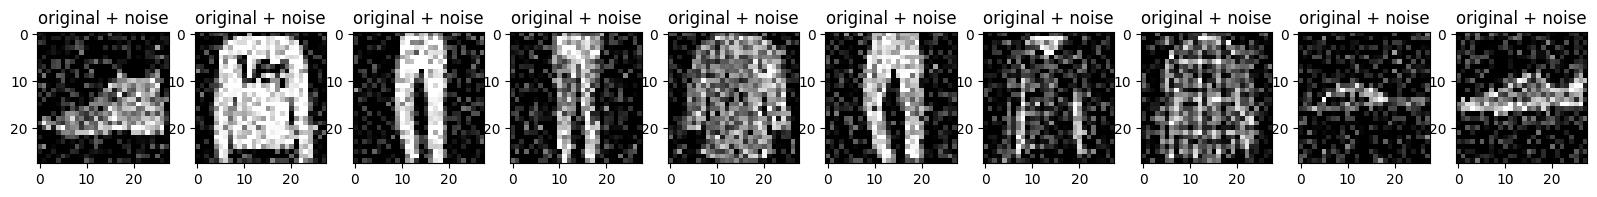

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Definir un autocodificador convolucional

En este ejemplo, entrenará un autocodificador convolucional con las capas [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) en el `encoder`, y las capas [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) en el `decoder`.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 63s 33ms/step - loss: 0.0185 - val_loss: 0.0116
Epoch 2/10
1875/1875 [==============================] - 57s 31ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 3/10
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 4/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 5/10
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 6/10
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 7/10
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 8/10
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 9/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/10
1875/1875 [==============================] - 67s 36m

Veamos un resumen del codificador. Note cómo se reduce el tamaño de las imágenes de 28x28 a 7x7.

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


El decodificador aumenta el tamaño de las imágenes de 7x7 a 28x28.

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se trazan las imágenes con ruido y las imágenes sin ruido generadas por el autocodificador.

In [18]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

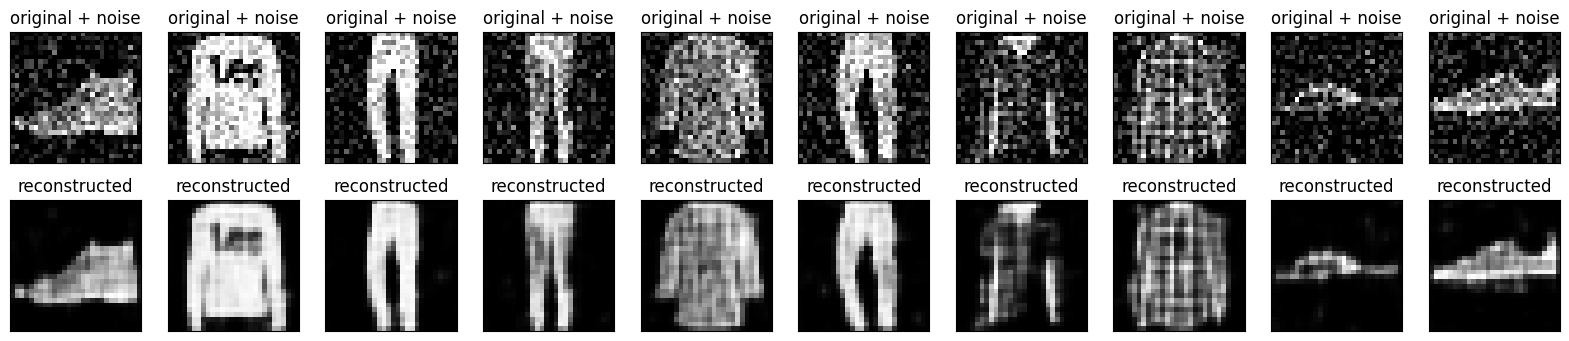

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Tercer ejemplo: detección de anomalías

## Descripción general

En este ejemplo, entrenará un autocodificador para detectar anomalías en el [conjunto de datos ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). Este conjunto de datos contiene 5000 [electrocardiogramas](https://en.wikipedia.org/wiki/Electrocardiography), cada uno con 140 puntos de datos. Usará una versión simplificada del conjunto de datos, donde cada ejemplo fue etiquetado con el número `0` (que corresponde a un ritmo cardíaco anormal) o con el número `1` (que corresponde a un ritmo cardíaco normal). Lo que se busca es identificar los ritmos anormales.

Nota: Este es un conjunto de datos etiquetados, así que podría formularse como un problema de aprendizaje supervisado. El objetivo de este ejemplo es ilustrar los conceptos de detección de anomalías que pueden aplicarse a conjuntos de datos más grandes, donde no hay etiquetas disponibles (por ejemplo, si tiene miles de ritmos cardíacos normales y solo una pequeña cantidad de ritmos cardíacos anormales).

¿Cómo se detectan las anomalías con el autocodificador? Recuerde que un autocodificador está entrenado para minimizar los errores de la reconstrucción. Entrenará un autocodificador solo con los ritmos cardíacos normales, y lo usará para reconstruir todos los datos. Nuestra hipótesis es que los ritmos cardíacos anormales presentarán más errores de reconstrucción. Luego de esto, usted clasificará un ritmo como anormal si el error de reconstrucción supera un umbral fijo.

### Cargar datos ECG

El conjunto de datos que usará se basa en uno de [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalizar los datos en `[0,1]`.


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Entrenará al autocodificador solo con los ritmos cardíacos normales, que están etiquetados en el conjunto de datos con el número `1`. Separe los ritmos normales de los ritmos anormales.

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Trace un ECG normal.

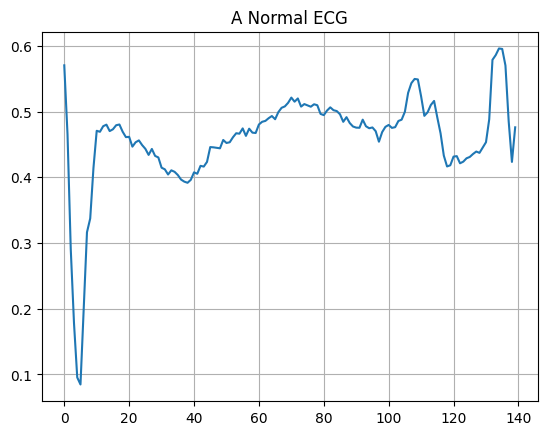

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Trace un ECG anormal.

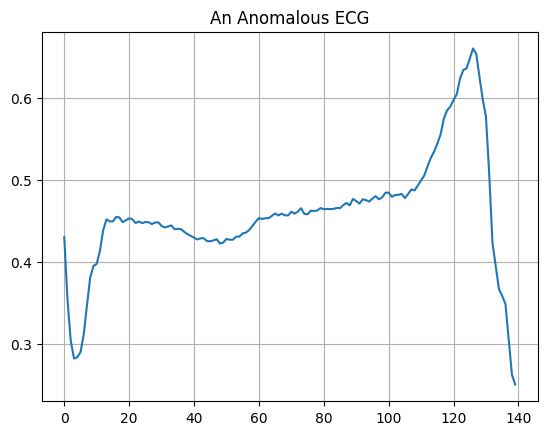

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Construir el modelo

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

Note como el autocodificador está entrenado solo con los ECG normales, pero se evalúa con todo el conjunto de prueba.

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 48ms/step - loss: 0.0570 - val_loss: 0.0528
Epoch 2/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0541 - val_loss: 0.0513
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0506 - val_loss: 0.0494
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0465 - val_loss: 0.0473
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0426 - val_loss: 0.0453
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0389 - val_loss: 0.0433
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0357 - val_loss: 0.0417
Epoch 8/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0329 - val_loss: 0.0403
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0306 - val_loss: 0.0390
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0285 - val_loss: 0.0380
Epoch 11/20
5/5 [===============

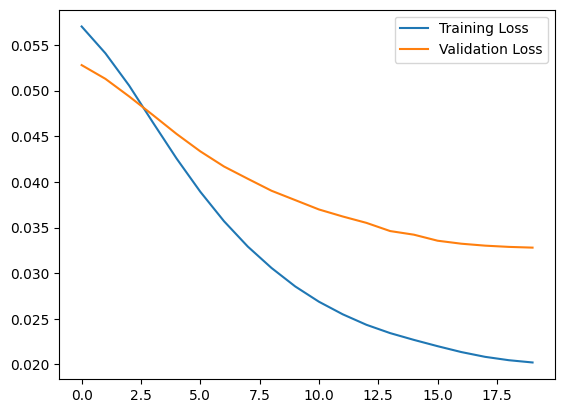

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Pronto clasificará un ECG como anormal si el error de reconstrucción es mayor a una desviación estándar de los ejemplos de entrenamiento normales. Primero, trazaremos un ECG normal con el conjunto de entrenamiento, la reconstrucción después de que el autocodificador lo codifique y descodifique  y el error de reconstrucción.

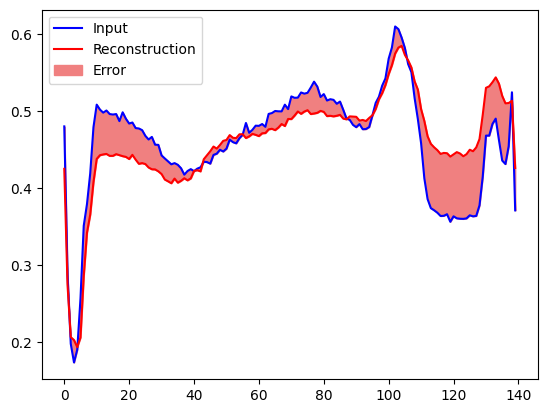

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Cree un trazado similar, pero ahora para un ejemplo de prueba anormal.

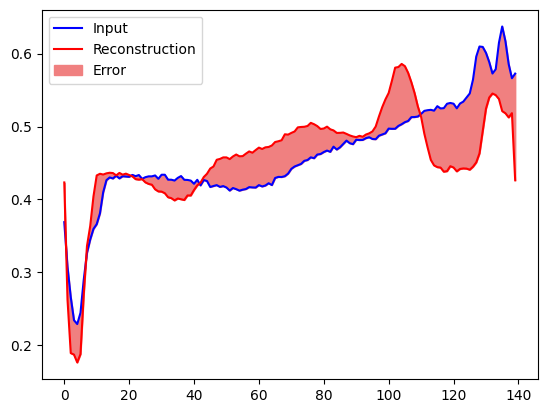

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detectar anomalías

Detecte anomalías al calcular si la pérdida de la reconstrucción es mayor al umbral fijo. En este tutorial, calculará el error promedio de la media para los ejemplos normales del conjunto de entrenamiento, luego clasificará los ejemplos futuros como anormales si el error de reconstrucción es mayor que la desviación estándar del conjunto de entrenamiento.


Trace el error de reconstrucción en los ECG normales del conjunto de entrenamiento.

74/74 [==============================] - 0s 2ms/step


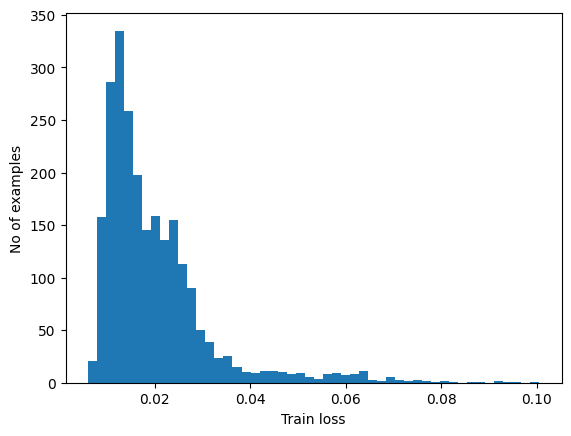

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Escoja un valor de umbral que esté una desviación estándar por sobre la media.

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032051492


Nota: Existen otras estrategias que se pueden usar para seleccionar un valor de umbral que se mencionó anteriormente, que debería clasificar a los ejemplos de prueba en anormales, el enfoque correcto dependerá de su conjunto de datos. Puede obtener más información en los enlaces al final de este tutorial.

SI examina el error de reconstrucción para los ejemplos anormales en el conjunto de prueba, notará que la mayoría tiene un valor de error de reconstrucción más alto que el umbral. Al variar el umbral, puede ajustar la [precisión](https://developers.google.com/machine-learning/glossary#precision) y [coincidencia](https://developers.google.com/machine-learning/glossary#recall) de su clasificador.

14/14 [==============================] - 0s 2ms/step


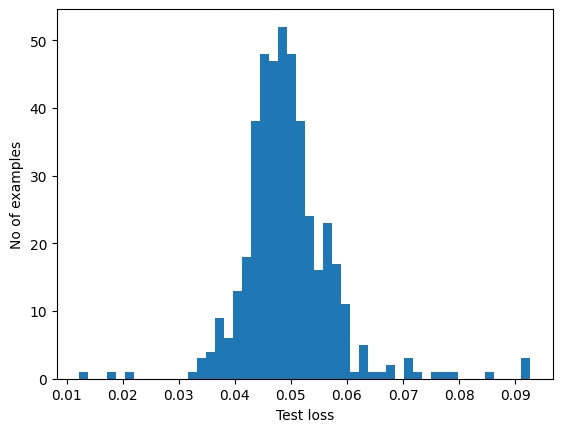

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Clasifique un ECG como anormal si el valor de error de reconstrucción es mayor que el umbral.

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714


## Próximos pasos

Para obtener más información sobre la detección de anomalías con autocodificadores, échele un vistazo a este [ejemplo interactivo](https://anomagram.fastforwardlabs.com/#/) generado con TensorFlow.js de Victor Dibia. Para ver un caso del mundo real, puede aprender cómo [Airbus detecta anomalías en datos de telemetría de ISS](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) con TensorFlow. Para más información sobre los fundamentos, considere esta [entrada de blog](https://blog.keras.io/building-autoencoders-in-keras.html) de François Chollet. Para más detalles, lea el capítulo 14 de [Aprendizaje profundo](https://www.deeplearningbook.org/) de Ian Goodfellow, Yoshua Bengio, y Aaron Courville.


##### Copyright 2020 The TensorFlow Authors.

In [37]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Autocodificador variacional convolucional

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     Ver en TensorFlow.org</a>
</td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/cvae.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     Ver código fuente en GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a>
</td>
</table>

En este cuaderno se enseña cómo entrenar un autocodificador variacional (VAE por sus siglas en inglés) ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)) en el conjunto de datos MNIST. Un VAE es un enfoque probabilístico del autocodificador, es un modelo que toma datos de entrada de alta dimensión y los comprime en una representación más pequeña. A diferencia de un autocodificador tradicional, que mapea la entrada en un vector latente, un VAE mapea los datos de entrada en parámetros de distribución de probabilidad, tales como la media y la varianza de una gaussiana. Este enfoque produce un espacio de latente continuo y estructurado, que sirve para generar una imagen.

![CVAE image latent space](images/cvae_latent_space.jpg)

## Preparación

In [38]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-qoyw_979
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-qoyw_979
  Resolved https://github.com/tensorflow/docs to commit a8576cef38b7182e6228d7aafca8ef51754ab9e8
  Preparing metadata (setup.py) ... done


In [39]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

## Cargar el conjunto de datos MNIST

Cada imagen de MNIST es originalmente un vector de 784 enteros, cada uno de entre 0 y 255 y representan la intensidad de un pixel. Modele cada pixel con la distribución de Bernoulli en nuestro modelo y convierta el conjunto de datos en binario de forma estática.

In [40]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [41]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [42]:
train_size = 60000
batch_size = 32
test_size = 10000

## Usar *tf.data* para poner los datos en lotes y en orden aleatorio

In [43]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Definir las redes del codificador y del decodificador con *tf.keras.Sequential*

En este ejemplo de VAE, use dos ConvNets pequeños para las redes del codificador y del decodificador. En la documentación, también se las conoce como inferencia/reconocimiento y modelos generativos respectivamente. Use `tf.keras.Sequential` para simplificar la implementación. Dejemos que $x$ y $z$ denoten la observación y la variable de latente respectivamente en las siguientes descripciones.

### Red del codificador

Define la distribución posterior aproximada de $q(z|x)$, que toma como entrada una observación y tiene como salida un conjunto de parámetros para especificar la distribución condicional de la representación latente $z$. En este ejemplo, simplemente modele la distribución como una gaussiana diagonal y la salida de la red será los parámetros de la media y de la varianza logarítmica de una gaussiana factorizada. Tiene como salida directamente el logaritmo de la varianza logarítmica en vez de la varianza para conservar la estabilidad numérica.

### Red del decodificador

Define la distribución condicional de la observación $p(x|z)$, que toma una muestra de latente $z$ como entrada y tiene como salida los parámetros para una distribución condicional de la observación. Modele la distribución latente antes de $p(z)$ como una gaussiana de unidad.

### Engaño de reparametrización

Para generar una muestra $z$ para el decodificador durante el entrenamiento, puede tomar una muestra de la distribución latente definida por los parámetros que salieron del codificador, al recibir una observación de entrada $x$. Sin embargo, esta operación de muestra crea un cuello de botella porque la retropropagación no puede fluir a través de un nodo aleatorio.

Para arreglar esto, use un engaño de reparametrización. En nuestro ejemplo, usted aproximará $z$ mediante el uso de los parámetros del decodificador y otro parámetro $\epsilon$ de la siguiente manera:

$$z = \mu + \sigma \odot \epsilon$$

donde $\mu$ y $\sigma$ representan la desviación media y estándar de una distribución gaussiana respectivamente. Pueden derivarse de la salida del decodificador. El $\epsilon$ puede ser considerado como un ruido aleatorio para conservar la estocasticidad de $z$. Genere $\epsilon$ a partir de una distribución normal estándar.

La variable latente $z$ ahora se genera mediante la función de $\mu$, $\sigma$ y $\epsilon$, que permitirá que el modelo retropropague gradientes en el codificador a través de $\mu$ y $\sigma$ respectivamente, mientras conserva la estocasticidad a través de $\epsilon$.

### La arquitectura de la red

Para la red del codificador, use dos capas convolucionales seguidas de una capa completamente conectada. En la red del decodificador, replique esta arquitectura usando una capa completamente conectada seguida de tres capas de convolución transpuesta (también conocidas como capas deconvolucionales en algunos contextos). Nota, es común evitar el uso de normalización de lotes cuando se entrenan las VAE, ya que la estocasticidad adicional causada por el uso de mini lotes puede agravar la inestabilidad además de la estocasticidad de las muestras.


In [44]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Definir la función de pérdida y el optimizador

Las VAE entrenan al maximizar el límite inferior de evidencia (ELBO, por sus siglas en inglés) en la probabilidad logarítmica marginal:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

En la práctica, optimice el cálculo estimado de Monte Carlo de la muestra única del siguiente valor esperado:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$ donde $z$ es una muestra de $q(z|x)$.

Nota: También puede calcular analíticamente el término KL, pero en este caso puede incorporar los tres términos en el estimador de Monte Carlo para que sea más simple.

In [45]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Entrenamiento

- Primero, iteramos el conjunto de datos
- Durante cada iteración, pase la imagen al codificador para obtener un conjunto de parámetros de la media y de la varianza de logaritmos de la posterior aproximada $q(z|x)$
- luego aplique el *engaño de reparametrización* para tomar una muestra de $q(z|x)$
- Por último, pase las muestras reparametrizadas al decodificador para obtener los logit de la distribución generativa $p(x|z)$
- Nota: Ya que se usó el conjunto de datos cargado mediante Keras con 60k puntos de datos en el conjunto de entrenamiento y 10k puntos de datos en el conjunto de prueba, nuestro ELBO resultante en el conjunto de prueba es un poco más alto que los resultados registrados en la documentación que usa una binarización dinámica de la MNIST de Larochelle.

### Generar imágenes

- Después del entrenamiento, es hora de generar algunas imágenes
- Para empezar,  tome una muestra del conjunto de vectores latentes de la gaussiana de unidad antes de la distribución $p(z)$
- Luego de esto, el generador convertirá la muestra latente  $z$ en logits de observación, lo que resultará en una distribución $p(x|z)$
- Aquí, puede trazar las probabilidades de las distribuciones de Bernoulli


In [46]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [47]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [48]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.50978088378906, time elapse for current epoch: 66.74884939193726


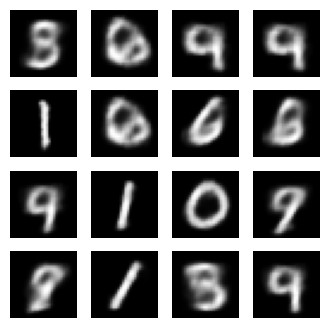

In [49]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### Mostrar una imagen generada en la última época del entrenamiento

In [50]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

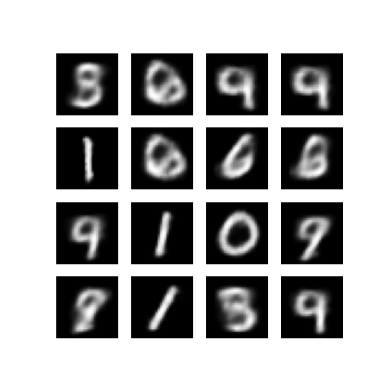

In [51]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Mostrar un GIF animado de todas las imágenes guardadas

In [52]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-52-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-52-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



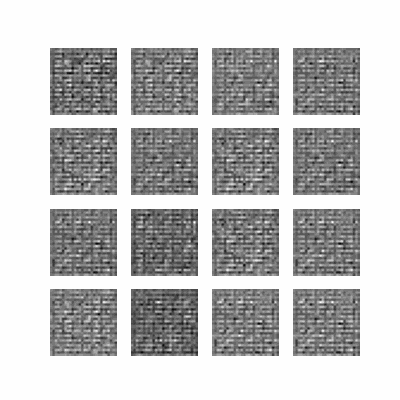

In [53]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Mostrar una variedad bidimensional de cifras del espacio latente

Al ejecutar el siguiente código, se mostrará una distribución continua de diferentes clases de cifras, con cada cifra transformándose en otra en todo el espacio latente bidimensional. Use [TensorFlow Probability](https://www.tensorflow.org/probability) para generar una distribución estándar normal para el espacio latente.

In [54]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

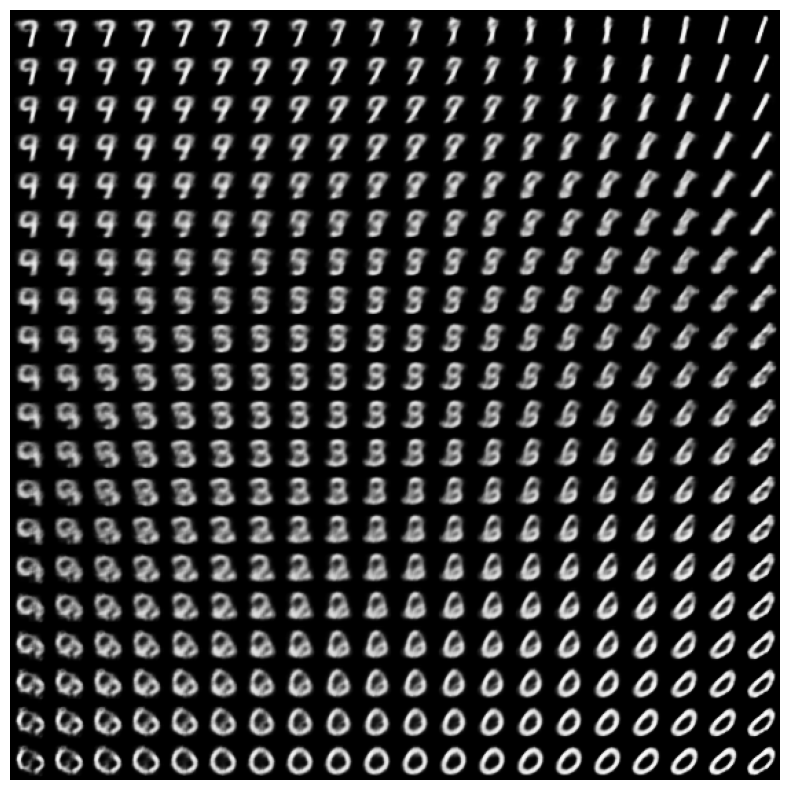

In [55]:
plot_latent_images(model, 20)

## Próximos pasos

En este tutorial, se explicó cómo implementar un autocodificador variacional convolucional con TensorFlow.

Su próximo paso puede ser intentar mejorar la salida del modelo al aumentar el tamaño de la red. Por ejemplo, puede intentar configurar los parámetros de `filter` para cada una de las capas `Conv2D` y `Conv2DTranspose` a 512. Tenga en cuenta que, para generar el trazado bidimensional de la imagen latente, deberá conservar `latent_dim` en 2. Además, el tiempo de entrenamiento se reducirá a medida que aumente el tamaño de la red.

También puede intentar implementar una VAE con un conjunto de datos diferente, como el CIFAR-10.

Las VAE pueden implementarse con diferentes estilos y diversas complejidades. Puede encontrar más implementaciones en los siguientes recursos:

- [Autocodificador variacional (keras.io)](https://keras.io/examples/generative/vae/)
- [Ejemplo de una VAE de la guia "Escribir capas y modelos personalizados" (tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [Capas de probabílistica de TFP: Autocodificador variacional](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

Si le gustaría obtener más información sobre los detalles de las VAE, vea [Una introducción a los autocodificadores variacionales](https://arxiv.org/abs/1906.02691).

##### Copyright 2022 The TensorFlow Compression Authors.

In [56]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Comprensión de datos aprendida

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/data_compression">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     Ver en TensorFlow.org</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/data_compression.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Ejecutar en Google Colab</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/generative/data_compression.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     Ver código fuente en GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/generative/data_compression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar bloc de notas</a>
</td>
</table>

## Descripción general

En este cuaderno se muestra como realizar la compresión con pérdida de datos con redes neuronales y [TensorFlow Compression](https://github.com/tensorflow/compression).

La compresión con pérdida de datos implica una compensación entre la **tasa**, el número previsto de bits que se necesitan para codificar una muestra, y la **distorsión**, el error previsto en la reconstrucción de la muestra.

Los ejemplos siguientes usan un modelo de tipo autocodificador que comprime imágenes del conjunto de datos MNIST. El método se basa en el artículo [Compresión optimizada de imágenes de extremo a extremo](https://arxiv.org/abs/1611.01704).

Puede encontrar más información sobre la compresión aprendida de datos en [este artículo](https://arxiv.org/abs/2007.03034) destinado a personas con conocimientos de la compresión de datos clásica o en [este estudio](https://arxiv.org/abs/2202.06533) para la audiencia de aprendizaje automático.


## Preparación

Instale Tensorflow Compression a través de `pip`.

In [57]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


  Using cached tensorflow_compression-2.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
Using cached tensorflow_compression-2.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (262 kB)


Importe las dependencias de la biblioteca.

In [58]:
!pip install tensorflow-compression==2.11.0

ERROR: Could not find a version that satisfies the requirement tensorflow-compression==2.11.0 (from versions: 2.12.0, 2.13.0, 2.14.0, 2.14.1)
ERROR: No matching distribution found for tensorflow-compression==2.11.0


In [59]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds


## Definir el modelo de entrenamiento.

Ya que el modelo se parece a un autocodificador y necesitamos que realice un conjunto de funciones diferentes durante el entrenamiento e inferencia, la instalación es un poco diferente a la de un clasificador, por ejemplo.

El modelo de entrenamiento consiste en tres partes:

- la transformación de **análisis** (o codificador), que convierte la imagen en un espacio latente,
- la transformación de **síntesis** (o decodificador), que vuelve a convertir el espacio latente en un espacio de imagen, y
- un modelo de **inferencia** y entrópico, que modela las probabilidades marginales de los latentes.

Primero, defina las transformaciones:

In [60]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


In [61]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


El entrenador conserva una instancia de ambas transformaciones y también los parámetros de la inferencia.

Se instala su método `call` para calcular:

- la **tasa**, un cálculo estimado de la cantidad de bits necesarios para representar un lote de cifras y
- la **distorsión**, la diferencia media absoluta entre los píxeles de las cifras originales y sus reconstrucciones.


In [62]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


### Calcular la tasa y la distorsión.

Vamos paso a paso, usaremos una imagen del conjunto de datos de entrenamiento. Cargue el conjunto de datos MNIST para el entrenamiento y la validación:

In [63]:
training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.R5XIN6_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.R5XIN6_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Y extraiga una imagen $x$:

Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


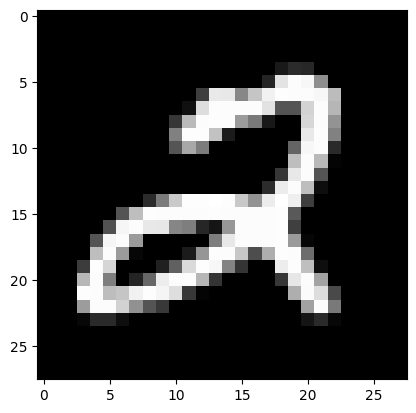

In [64]:
(x, _), = validation_dataset.take(1)

plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


Para obtener la representación latente $y$, necesitamos convertirla en `float32`, agregar una dimensión del lote y pasarla por la transformación de análisis.

In [65]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)

print("y:", y)


y: tf.Tensor(
[[ 0.06366619 -0.1017593  -0.07352808 -0.00983573  0.02648976 -0.02952994
  -0.06527349 -0.13984153  0.13644588 -0.08500361]], shape=(1, 10), dtype=float32)


Los latentes serán cuantificados durante el periodo de prueba. Para modelarlo de manera diferenciable durante el entrenamiento, agregamos ruido uniforme en el intervalo $(-.5, .5)$ y llamamos al resultado $\tilde y$. Esta es la misma terminología que se usa en el artículo [Compresión optimizada de imágenes de extremo a extremo](https://arxiv.org/abs/1611.01704).

In [66]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

print("y_tilde:", y_tilde)


y_tilde: tf.Tensor(
[[-0.10183505  0.22076465  0.11171147  0.19618748  0.05594518  0.23329985
  -0.19758758 -0.05620906  0.16591072  0.25517023]], shape=(1, 10), dtype=float32)


La "inferencia" es la densidad de la probabilidad que entrenamos para modelar la distribución marginal de los latentes con ruido. Por ejemplo, puede ser un conjunto de [distribuciones logísticas](https://en.wikipedia.org/wiki/Logistic_distribution) con diferentes escalas para cada dimensión latente. `tfc.NoisyLogistic` explica el hecho de que las latentes tengan ruido agregado. Ya que la escala está cerca del cero, una distribución logística se encuentra cerca de la delta de Dirac (pico), pero el ruido agregado causa la distribución "ruidosa" para acercarse más a la distribución uniforme.

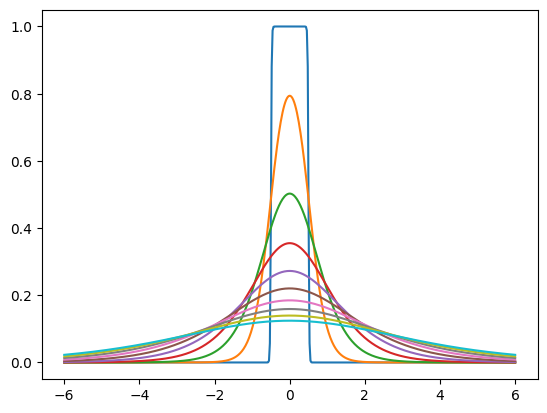

In [67]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


Durante el entrenamiento, `tfc.ContinuousBatchedEntropyModel` agrega ruido uniforme y usa el ruido y la inferencia para calcular un límite superior (diferenciable) en la tasa (cantidad promedio de bits necesarios para codificar la representación latente). Ese límite puede minimizarse como una pérdida.

In [68]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
print("y_tilde:", y_tilde)


rate: tf.Tensor([18.15109], shape=(1,), dtype=float32)
y_tilde: tf.Tensor(
[[ 0.01188966  0.00317098  0.40898475  0.02089976  0.2661021  -0.27802968
  -0.16556999 -0.49126884  0.24847782 -0.50613046]], shape=(1, 10), dtype=float32)


Por último, se pasan las latentes con ruido a través de la transformación de síntesis para producir la reconstrucción de la imagen $\tilde x$. La distorsión es el error entre la imagen original y la reconstrucción. Obviamente, si no se entrenan las transformaciones, la reconstrucción no es muy útil.

distortion: tf.Tensor(0.17103907, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


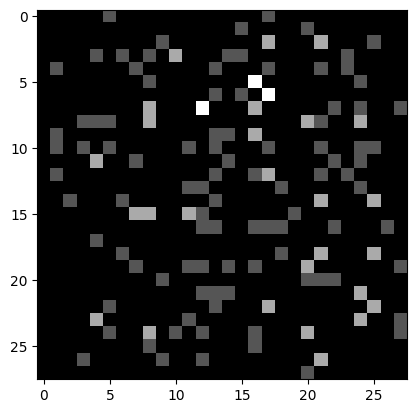

In [69]:
x_tilde = make_synthesis_transform()(y_tilde)

# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


Para cada lote de cifras, si se llama a `MNISTCompressionTrainer`, este produce la tasa y la distorsión como un promedio sobre ese lote:


In [70]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14659302, shape=(), dtype=float32)


En la siguiente sección, instalaremos el modelo para hacer que el gradiente descienda en las dos pérdidas.

## Entrenar el modelo.

Compilamos el entrenador para que optimice la tasa y la distorsión lagareanas, es decir, la suma de la tasa y la distorsión, donde uno de los términos se evalúa con el parámetro $\lambda$ de Lagrange.

Esta función de pérdida afecta a diferentes partes del modelo de distintas formas:

- La transformación de análisis se entrena para producir una representación latente que logre la compensación deseada entre la tasa y la distorsión.
- La transformación de síntesis se entrena para minimizar la distorsión, según la representación latente.
- Los parámetros de la inferencia se entrenan para minimizar la tasa según la representación latente. Es idéntico a encajar la inferencia en la distribución marginal de latentes en un sentido de probabilidad máxima.

In [71]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


Luego, entrene el modelo. Las anotaciones de personas no son necesarias aquí, ya que solo queremos comprimir las imágenes, por eso las abandonamos con `map` y en su lugar agregamos destinos "de relleno" para la tasa y la distorsión.

In [72]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)


Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 216.9980 - distortion_loss: 0.0585 - rate_loss: 100.0636 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 100.0588

469/469 [==============================] - 77s 157ms/step - loss: 216.9980 - distortion_loss: 0.0585 - rate_loss: 100.0636 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 100.0588 - val_loss: 176.5956 - val_distortion_loss: 0.0422 - val_rate_loss: 92.1612 - val_distortion_pass_through_loss: 0.0422 - val_rate_pass_through_loss: 92.1691
Epoch 2/15
469/469 [==============================] - 67s 143ms/step - loss: 166.2812 - distortion_loss: 0.0412 - rate_loss: 83.9635 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 83.9591 - val_loss: 156.4650 - val_distortion_loss: 0.0406 - val_rate_loss: 75.2760 - val_distortion_pass_through_loss: 0.0406 - val_rate_pass_through_loss: 75.2926
Epoch 3/15
469/469 [==============================] - 67s 143ms/step - loss: 151.1099 - distortion_loss: 0.0400 - rate_loss: 71.0941 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.0912 - val_loss: 144.7444 - val_distortion_loss: 0.0405 - val_rate_loss: 63.6470 -

## Comprimir algunas imágenes MNIST.

Para comprimir y descomprimir durante el periodo de prueba, dividimos el modelo de entrenamiento en dos partes:

- La parte del codificador que consiste en la transformación de análisis y el modelo de entropía.
- La parte del decodificador que consiste en la transformación de síntesis y el mismo modelo de entropía.

En este momento, las latentes no tienen ruido agregado, pero se cuantificarán y luego se comprimirán sin pérdida así que pondremos nombres nuevos. Los llamamos y a la imagen de reconstrucción $\hat x$ y $\hat y$, respectivamente (como se presenta en [Comprensión optimizada de imágenes de extremo a extremo](https://arxiv.org/abs/1611.01704)).

In [73]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [74]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)


Cuando se crea una instancia con `compression=True`, el modelo de entropía convierte la inferencia aprendida en tablas para un algoritmo de codificación de rango. Cuando se llama a `compress()`, se invoca este algoritmo para convertir el vector del espacio latente en secuencias de bit. El largo de cada cadena de texto binaria se aproxima al contenido de datos de la latente (la probabilidad logarítmica negativa de la latente bajo la inferencia).

El modelo de entropía para comprimir y descomprimir debe ser la misma instancia, porque las tablas de codificación de rango tienen que ser exactamente idénticas en ambos lados. Si no es así, pueden ocurrir errores de decodificación.

In [75]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)


Tome 16 imágenes del conjunto de datos de validación. Puede seleccionar un subconjunto diferente si cambia el argumento a `skip`.

In [76]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)


Comprímalas en cadenas de texto y lleve la cuenta de sus contenidos de datos en bits.

In [77]:
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first digit in hexadecimal: 0xd82f06508204
Number of bits actually needed to represent it: 44.16


Descomprima las cadena de texto a imágenes.

In [78]:
reconstructions = decompressor(strings)


Muestre cada una de las 16 cifras originales junto a sus representaciones binarias y la cifra reconstruida.

In [79]:
#@title

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


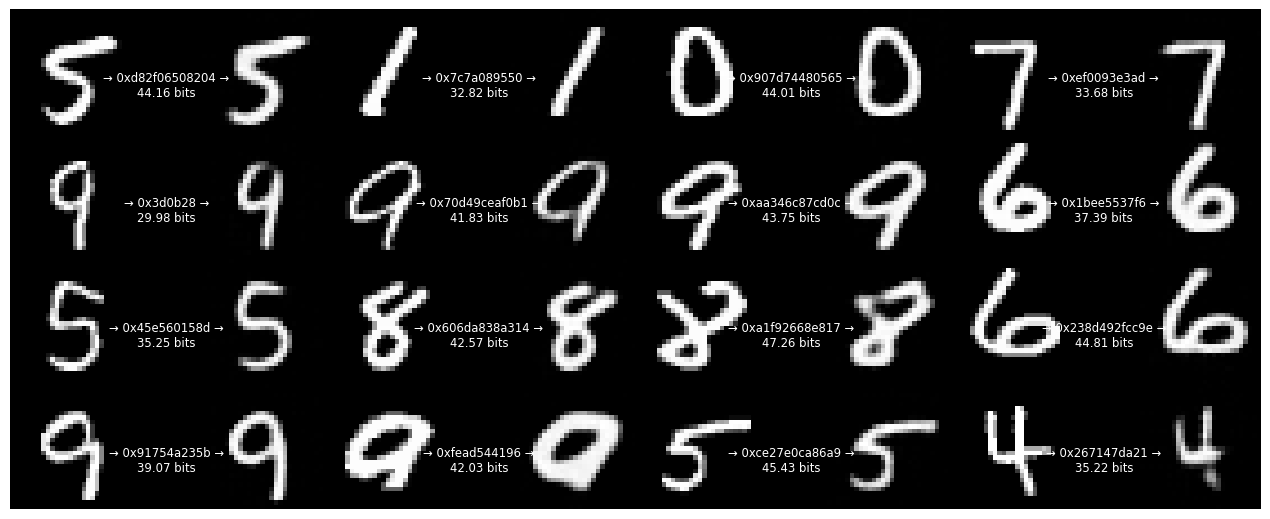

In [80]:
display_digits(originals, strings, entropies, reconstructions)


Preste atención a como a longitud de la cadena codificada es diferente al contenido de datos de cada cifra.

Esto se debe a que el proceso de codificación de rango funciona con probabilidades discretas y tiene una breve sobrecarga. Por lo tanto, especialmente para las cadenas de texto cortas, la correspondencia solo es aproximada. Sin embargo, la codificación de rango es **óptima de forma asintótica**: en el límite, el conteo esperado de bits se acercará a la entropía cruzada (el contenido de datos esperado) para el cual el término de la tasa en el modelo de entrenamiento es un límite superior.

## La compensación de tasa y distorsión

Anteriormente, se entrenó el modelo para una compensación específica (dada por `lmbda=2000`) entre la cantidad promedio de bits usados para representar cada cifra y el error resultante durante la reconstrucción.

¿Qué sucede si intentamos el experimento de nuevo con diferentes valores?

Empecemos por reducir $\lambda$ a 500.

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 127.5015 - distortion_loss: 0.0699 - rate_loss: 92.5421 - distortion_pass_through_loss: 0.0699 - rate_pass_through_loss: 92.5359

469/469 [==============================] - 70s 143ms/step - loss: 127.5015 - distortion_loss: 0.0699 - rate_loss: 92.5421 - distortion_pass_through_loss: 0.0699 - rate_pass_through_loss: 92.5359 - val_loss: 107.5699 - val_distortion_loss: 0.0554 - val_rate_loss: 79.8679 - val_distortion_pass_through_loss: 0.0554 - val_rate_pass_through_loss: 79.8664
Epoch 2/15
469/469 [==============================] - 68s 145ms/step - loss: 97.2041 - distortion_loss: 0.0540 - rate_loss: 70.2188 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.2136 - val_loss: 86.2424 - val_distortion_loss: 0.0605 - val_rate_loss: 56.0160 - val_distortion_pass_through_loss: 0.0604 - val_rate_pass_through_loss: 56.0144
Epoch 3/15
469/469 [==============================] - 71s 150ms/step - loss: 81.1801 - distortion_loss: 0.0562 - rate_loss: 53.0859 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.0821 - val_loss: 71.6855 - val_distortion_loss: 0.0674 - val_rate_loss: 37.9680 - val_d

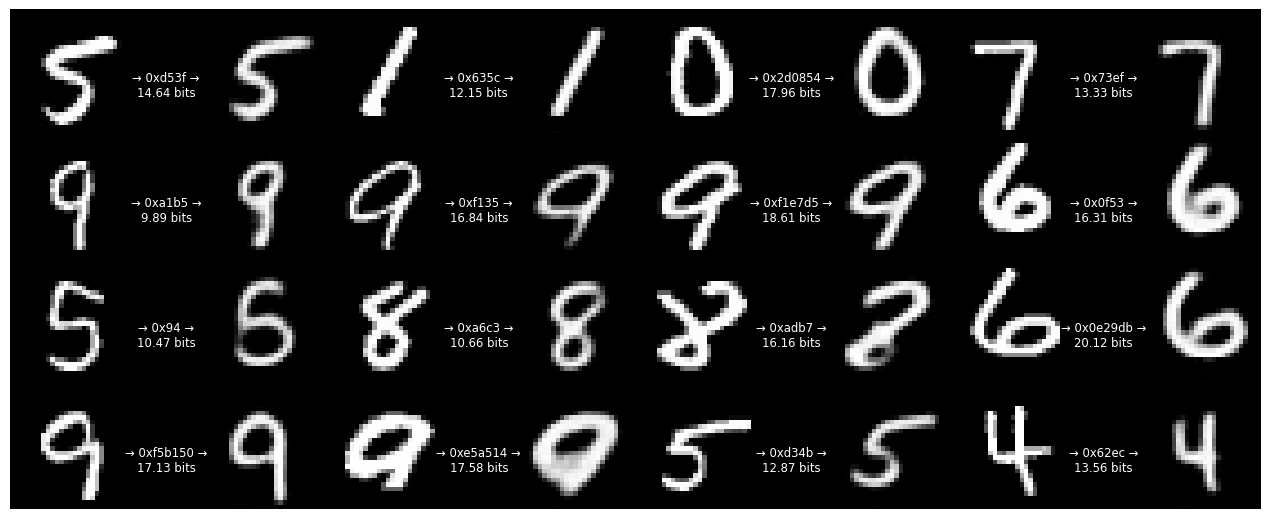

In [81]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

train_and_visualize_model(lmbda=500)


La tasa de bits de nuestro código disminuye, al igual que la fidelidad de las cifras. Sin embargo, la mayoría de las cifras siguen siendo reconocibles.

Reduzcamos $\lambda$ un poco más.

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 113.9077 - distortion_loss: 0.0763 - rate_loss: 91.0222 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 91.0157

469/469 [==============================] - 75s 153ms/step - loss: 113.9077 - distortion_loss: 0.0763 - rate_loss: 91.0222 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 91.0157 - val_loss: 96.4440 - val_distortion_loss: 0.0666 - val_rate_loss: 76.4722 - val_distortion_pass_through_loss: 0.0666 - val_rate_pass_through_loss: 76.4757
Epoch 2/15
469/469 [==============================] - 68s 145ms/step - loss: 85.7983 - distortion_loss: 0.0609 - rate_loss: 67.5254 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 67.5199 - val_loss: 74.2182 - val_distortion_loss: 0.0765 - val_rate_loss: 51.2567 - val_distortion_pass_through_loss: 0.0766 - val_rate_pass_through_loss: 51.2521
Epoch 3/15
469/469 [==============================] - 68s 145ms/step - loss: 68.7554 - distortion_loss: 0.0643 - rate_loss: 49.4595 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.4560 - val_loss: 58.8817 - val_distortion_loss: 0.0923 - val_rate_loss: 31.1904 - val_di

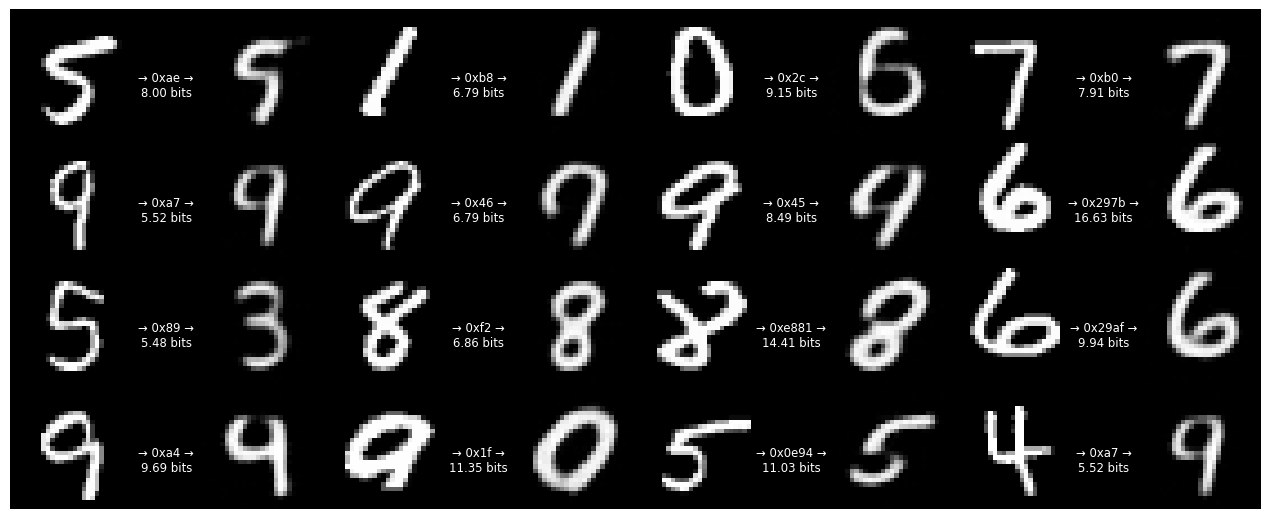

In [82]:
train_and_visualize_model(lmbda=300)


Ahora, las cadenas de texto se van acortando, un byte por cifra. Pero esto sucede a un costo. Cada vez más cifras se vuelven irreconocibles.

Esto demuestra que este modelo es agnóstico a la capacidad humana de reconocer los errores, solo mide la desviación absoluta en términos de valores de píxeles. Para lograr una calidad de imagen mejor percibida, tendremos que reemplazar la pérdida de píxeles con la pérdida de percepción.

## Usar el decodificador como modelo generativo.

Si ingresamos bits aleatorios en el decodificador, este tomará efectivamente la distribución que el modelo aprendió para representar cifras como muestra.

Primero, vuelva a crear la instancia del compresor/descompresor sin una verificación de sanidad que pueda detectar si la cadena de texto de entrada fue decodificada completamente.

In [83]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)


Ahora, ingrese cadenas de texto aleatorias con una buena longitud en el descompresor para que pueda decodificar/tomar la muestra de las cifras.

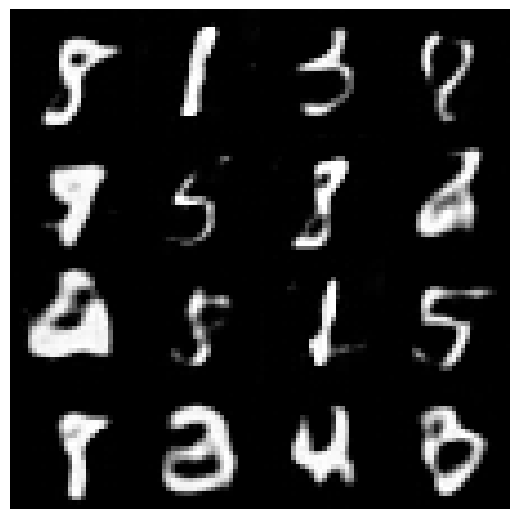

In [84]:
import os

strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
